# Calculating features

In [ ]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50 #--- good
from keras.applications.resnet50 import preprocess_input
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input
#from keras.applications.vgg16 import VGG16 --- ok-ish
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.xception import Xception --- bad
#from keras.applications.xception import preprocess_input
#from keras.applications.inception_resnet_v2 import InceptionResNetV2 ---ok-ish
#from keras.applications.inception_resnet_v2 import preprocess_input
#from keras.applications.nasnet import NASNetLarge --- bad
#from keras.applications.nasnet import preprocess_input

#from keras.applications.densenet import DenseNet201 #--- good
#from keras.applications.densenet import preprocess_input

import numpy as np
import pandas as pd
from os.path import join
import os

import matplotlib.pyplot as plt

In [ ]:
regions = ['borde_rural', 'borde_soacha', 'mixco_1_and_ebenezer', 'mixco_3']

In [ ]:
region = 'curated'
train_dir = join('..', '..', 'data', 'data2', region, 'roofs_train')
test_dir = join('..', '..', 'data', 'data2', region, 'roofs_test')
materials = {'concrete_cement':0, 'healthy_metal':1, 'incomplete':2, 'irregular_metal':3, 'other':4}

Use a pretrained network to compute features from the images, which are later classified. Import the model from the Kerase library and remove the top layer by setting `include_top=False`. The last layer is pooled such that we get outputs of size 1x2048 instead of 7x7x2048. The pooling method `'max'` is chosen empirically.

In [ ]:
model = ResNet50(weights='imagenet', include_top=False, pooling='max', classes=1000)
model.summary()

## 1. Calculate features on the training data

The preprocessed data is stored in such a way, that every region has their own folder, that contains a subfolder defined as `train_dir` above. This folder again is subdivided by material. Images carry their `id` as filename.

Traverse all images in their corresponding folders which indicate the material and use `model.predict()` to get the features.

In [2]:
def calculate_features_train(train_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features', 'label']
    df_features = pd.DataFrame(columns=columns)
    
    data = []

    # Walk through all images
    for material in materials.keys():
        material_fp = join(train_dir, material)
        for root, dirs, files in os.walk(material_fp):
            for file in files:
                img_fp = join(material_fp, file)
                label = materials[material]
                id = file.split('.')[0]
                print(id, "labeled as", material, ":", label)

                # Pad if size is too small, preprocess
                img = image.load_img(img_fp, target_size=(224, 224))
                img_data = image.img_to_array(img)
                #plt.imshow(img_data, vmin=0, vmax=1)
                print(img_data)
                img_data = np.expand_dims(img_data, axis=0)
                img_data = preprocess_input(img_data)

                # Compute features 
                features = model.predict(img_data)
                features_np = np.array(features).flatten()

                data.append({'id': id ,
                             'features': features_np,
                             'label': label})
                #df_features = df_features.append({'id': id ,
                #                                  'features': resnet50_feature_np,
                #                                  'label': label}, ignore_index=True)
    
    df_features = pd.DataFrame(data)
    return df_features

The results are stored in a dataframe as shown below and saved to disk as a pickle file.

In [3]:
print(train_dir)

NameError: name 'train_dir' is not defined

In [17]:
features_train = calculate_features_train(train_dir)

7a3afb66 labeled as concrete_cement : 0
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


NameError: name 'model' is not defined

In [39]:
features_train.head()

,id,features,label
0,7a3afb66,"[0.45864525, 5.2694483, 0.98710173, 1.0466, 0....",0
1,7a33dd36,"[2.5096273, 11.350532, 0.90789247, 0.25257438,...",0
2,7a3ecf2a,"[2.6802056, 11.660908, 0.46674225, -0.0, 2.052...",0
3,7a2689d8,"[0.29388046, 5.9449034, 0.5586918, 1.1351435, ...",0
4,7a3cf704,"[-0.0, 14.118133, 2.319159, 1.8467202, 0.27513...",0


In [40]:
len(features_train.features[0])

2048

In [41]:
import pickle
from os import makedirs
from os.path import exists

pickle_path = join('..', '..', 'pickles')
if not exists(pickle_path):
    makedirs(pickle_path)

#with open(join(pickle_path, 'resnet50_avg_features_' + region + '_train.pkl' ), 'wb') as f:
#    pickle.dump(features_train, f)

### Visualize the features

Reduce the dimensionality to 2D using tSNE (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from sklearn.decomposition import PCA
%matplotlib inline

In [43]:
def plot_tSNE(features, labels=None, number_of_materials=5, title='default_title', path='.'):
    if labels is None:
        labels = np.zeros((features.shape[0]))

    # Visualization_
    #pca_object = PCA(n_components=50)
    #pca_features = pca_object.fit_transform(features)
    tsne_features = TSNE(n_components=2).fit_transform(features)

    # define the colormap
    cmap = plt.cm.jet
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(0, number_of_materials, number_of_materials + 1)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    print(tsne_features.shape)

    plt.figure()
    plt.title(title)
    scat = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap=cmap, norm=norm)
    cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
    plt.savefig(join(path, title+'.png'))

Convert features within the dataframe to a single matrix

In [44]:
feat_matrix = features_train['features'].to_numpy()
feat_matrix = np.column_stack(feat_matrix).transpose()

labels = features_train['label'].to_numpy()

In [45]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(feat_matrix)
feat_matrix_scaled = scaler.transform(feat_matrix)

(208, 2)


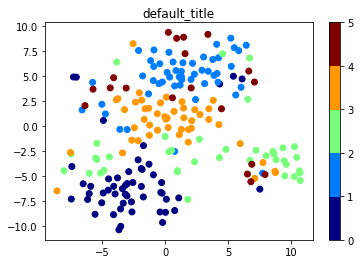

In [47]:
results_dir = join('..', '..', 'results')
plot_tSNE(feat_matrix, labels, path=results_dir)

## 2. Calculate features on the test data


This procedure is similar as for the training data, except that we do not know the labels and the folder with test images is not subdivided by material

In [82]:
def calculate_features_test(test_dir):
    
    # Initialize a dataframe for the features    
    columns = ['id', 'features']
    df_features = pd.DataFrame(columns=columns)

    # Walk through all images
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            img_fp = join(root, file)
            id = file.split('.')[0]
            print("Calculate features for", id)

            # Pad if size is too small, preprocess
            img = image.load_img(img_fp, target_size=(224, 224))
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)

            # Compute features 
            features = model.predict(img_data)
            features_np = np.array(features).flatten()

            df_features = df_features.append({'id': id ,
                                              'features': features_np},
                                             ignore_index=True)

    return df_features

In [83]:
features_test = calculate_features_test(test_dir)

Calculate features for 7a4c2b20
Calculate features for 7a4e473e
Calculate features for 7a4d97ee
Calculate features for 7a48ccaa
Calculate features for 7a4cd8a4
Calculate features for 7a47ecc2
Calculate features for 7a45e7a6
Calculate features for 7a4e83f2
Calculate features for 7a468b3e
Calculate features for 7a4a60b0
Calculate features for 7a48d1a0
Calculate features for 7a491b24
Calculate features for 7a4a35c2
Calculate features for 7a49f76a
Calculate features for 7a469ce6
Calculate features for 7a4cdab6
Calculate features for 7a49bfe8
Calculate features for 7a4bfc90
Calculate features for 7a49d7a8
Calculate features for 7a4ffaa2
Calculate features for 7a4bd5b2
Calculate features for 7a499e6e
Calculate features for 7a486b48
Calculate features for 7a4705e6
Calculate features for 7a4eef5e
Calculate features for 7a48e636
Calculate features for 7a507e8c
Calculate features for 7a4f3ff4
Calculate features for 7a44e96e
Calculate features for 7a4bd968
Calculate features for 7a4cabf4
Calculat

/root/anaconda3/envs/ipeo/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (99907344 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Calculate features for 7a47314c
Calculate features for 7a4e7614
Calculate features for 7a455fac
Calculate features for 7a51497a
Calculate features for 7a48f6b2
Calculate features for 7a4d6f44
Calculate features for 7a47b8f6
Calculate features for 7a4bb820
Calculate features for 7a46f4b6
Calculate features for 7a4e58f0
Calculate features for 7a4aadc2
Calculate features for 7a4e8e24
Calculate features for 7a48f572
Calculate features for 7a4b4174
Calculate features for 7a44fbd4
Calculate features for 7a452708
Calculate features for 7a507e1e
Calculate features for 7a4d3326
Calculate features for 7a4c56c2
Calculate features for 7a51df2a
Calculate features for 7a4ebd54
Calculate features for 7a49774a
Calculate features for 7a4ff066
Calculate features for 7a4c4056
Calculate features for 7a4ec6b4
Calculate features for 7a500ba0
Calculate features for 7a4ffe44
Calculate features for 7a4eb7f0
Calculate features for 7a4f0458
Calculate features for 7a4fad04
Calculate features for 7a4f70c8
Calculat

Calculate features for 7a4a6b00
Calculate features for 7a4f1a2e
Calculate features for 7a483bc8
Calculate features for 7a488042
Calculate features for 7a47f71c
Calculate features for 7a4d714c
Calculate features for 7a4a9c74
Calculate features for 7a481ef4
Calculate features for 7a4a5020
Calculate features for 7a4ac7b2
Calculate features for 7a4506b0
Calculate features for 7a4b15d2
Calculate features for 7a4ddcd6
Calculate features for 7a4bb474
Calculate features for 7a5018b6
Calculate features for 7a4b83fa
Calculate features for 7a4e4f72
Calculate features for 7a4dab94
Calculate features for 7a4a8df6
Calculate features for 7a4de0e6
Calculate features for 7a493870
Calculate features for 7a48f3ce
Calculate features for 7a4915c0
Calculate features for 7a484f82
Calculate features for 7a4e22e0
Calculate features for 7a4c8598
Calculate features for 7a4c6a18
Calculate features for 7a4dada6
Calculate features for 7a49ecf2
Calculate features for 7a4aacf0
Calculate features for 7a4951f2
Calculat

In [84]:
features_test.head()

,id,features
0,7a4c2b20,"[0.13613133, 0.3479903, 0.15979975, 0.00294684..."
1,7a4e473e,"[0.5942232, 0.8656745, 0.047772426, 0.160413, ..."
2,7a4d97ee,"[0.06035686, 0.4927775, 0.5255877, 0.0, 0.0, 0..."
3,7a48ccaa,"[0.483567, 0.94683397, 0.28378797, 0.0, 0.0, 0..."
4,7a4cd8a4,"[0.6701146, 0.3944776, 0.41654548, 0.0, 0.0, 0..."


In [85]:
import pickle
pickle_path = join('..', '..', 'pickles')
with open(join(pickle_path, 'resnet50_avg_features_' + region + '_test.pkl' ), 'wb') as f:
    pickle.dump(features_test, f)